# COURSE: MODEL ENGINEERING DLMDSME01

## CASE STUDY: AUTOMATION OF STANDBY DUTY PLANNING 
## FOR RESCUE DRIVERS VIA A FORECASTING MODEL

### Author: Husam Romman

## Final

## 1- import dependensies 


In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from pathlib import Path  
import datetime 

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import plot_importance, plot_tree


from sklearn.model_selection import GridSearchCV
import xgboost as xgb

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"]=(20,10) # for graphs styling
plt.style.use("tableau-colorblind10") # for graph stying
%matplotlib inline

## 2- Data: import & explore

In [2]:
df = pd.read_csv('Data/sickness_table.csv')
df.head(3)

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0


In [3]:
df.shape

(1152, 8)

In [4]:
df.columns

Index(['Unnamed: 0', 'date', 'n_sick', 'calls', 'n_duty', 'n_sby', 'sby_need',
       'dafted'],
      dtype='object')

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1152.0,575.500000,332.698061,0.0,287.75,575.5,863.25,1151.0
n_sick,1152.0,68.808160,14.293942,36.0,58.00,68.0,78.00,119.0
calls,1152.0,7919.531250,1290.063571,4074.0,6978.00,7932.0,8827.50,11850.0
n_duty,1152.0,1820.572917,80.086953,1700.0,1800.00,1800.0,1900.00,1900.0
n_sby,1152.0,90.000000,0.000000,90.0,90.00,90.0,90.00,90.0
sby_need,1152.0,34.718750,79.694251,0.0,0.00,0.0,12.25,555.0
dafted,1152.0,16.335938,53.394089,0.0,0.00,0.0,0.00,465.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1152 non-null   int64  
 1   date        1152 non-null   object 
 2   n_sick      1152 non-null   int64  
 3   calls       1152 non-null   float64
 4   n_duty      1152 non-null   int64  
 5   n_sby       1152 non-null   int64  
 6   sby_need    1152 non-null   float64
 7   dafted      1152 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 72.1+ KB


## 3- data cleaning, formating, transformation 



### Check missing values


In [7]:
df.isnull().sum()

Unnamed: 0    0
date          0
n_sick        0
calls         0
n_duty        0
n_sby         0
sby_need      0
dafted        0
dtype: int64

In [8]:
df.notna().count()

Unnamed: 0    1152
date          1152
n_sick        1152
calls         1152
n_duty        1152
n_sby         1152
sby_need      1152
dafted        1152
dtype: int64

The results show that our dataset has no missing values.


### Clean

In [9]:
# drop unneded column
df = df.drop(['Unnamed: 0'], axis =1)

### Format date

In [10]:
# make date as index
df['timestamp'] = df['date'].apply( lambda x : pd.Timestamp(x))
df.set_index('timestamp', inplace = True)

In [11]:
df.head(3)

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
timestamp,,,,,,,
2016-04-01,2016-04-01,73,8154.0,1700,90,4.0,0.0
2016-04-02,2016-04-02,64,8526.0,1700,90,70.0,0.0
2016-04-03,2016-04-03,68,8088.0,1700,90,0.0,0.0


In [12]:
# save df
filepath = Path('Data/d_sickness_table_clean_final.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath) 

## 4- visualization & understanding the data

The lineplot() function from the seaborn toolbox (https://seaborn.pydata.org/) is intended for exploring linear relationships. Let us try it out.

### Distribution


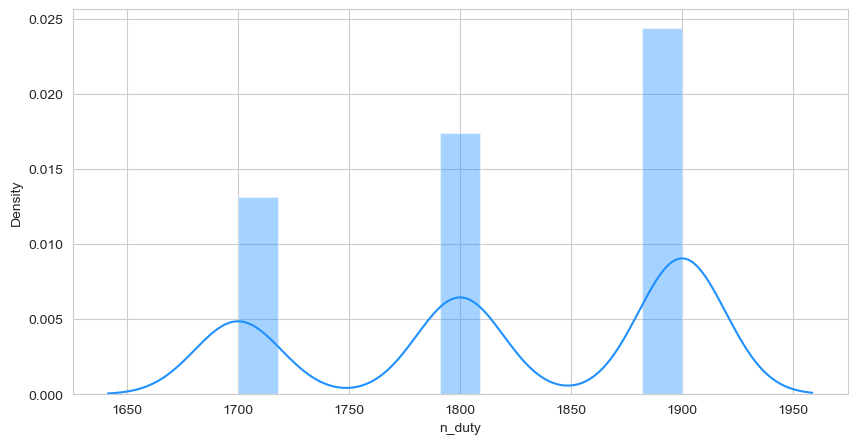

In [13]:
plt.figure(figsize=(10,5))
sns.distplot(df["n_duty"], color="dodgerblue")

# save the figure
plt.savefig('images/n_duty_dist.png', dpi=300, bbox_inches='tight')

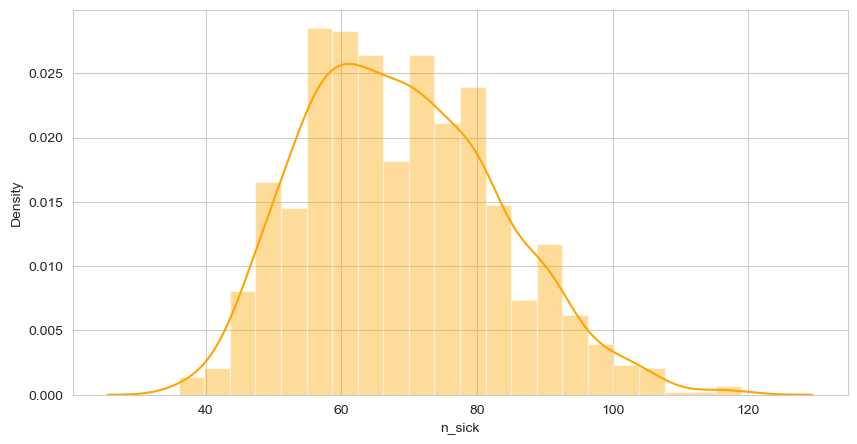

In [14]:
plt.figure(figsize=(10,5))
sns.distplot(df["n_sick"], color="orange")
# save the figure
plt.savefig('images/n_sick_dist.png', dpi=300, bbox_inches='tight')

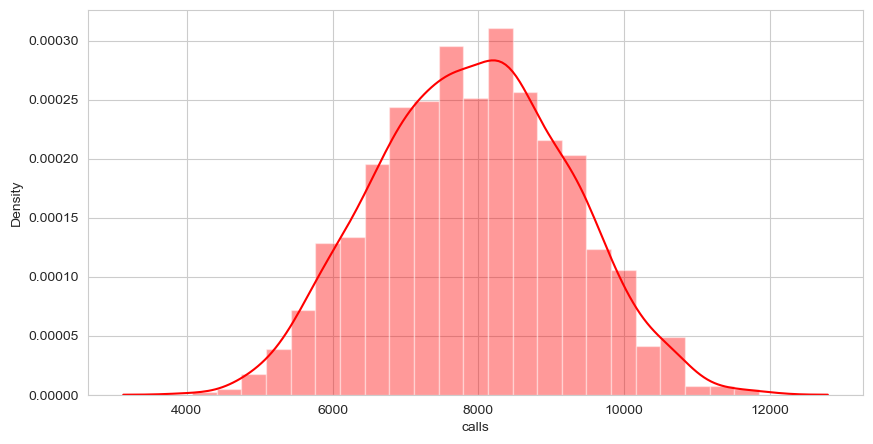

In [15]:
plt.figure(figsize=(10,5))
sns.distplot(df["calls"], color="red")
# save the figure
plt.savefig('images/calls_dist.png', dpi=300, bbox_inches='tight')

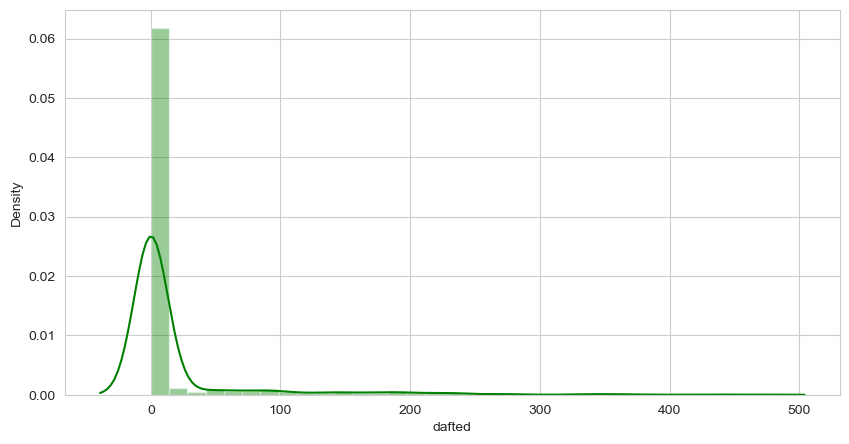

In [16]:
plt.figure(figsize=(10,5))
sns.distplot(df["dafted"], color="green")
# save the figure
plt.savefig('images/dafted_dist.png', dpi=300, bbox_inches='tight')

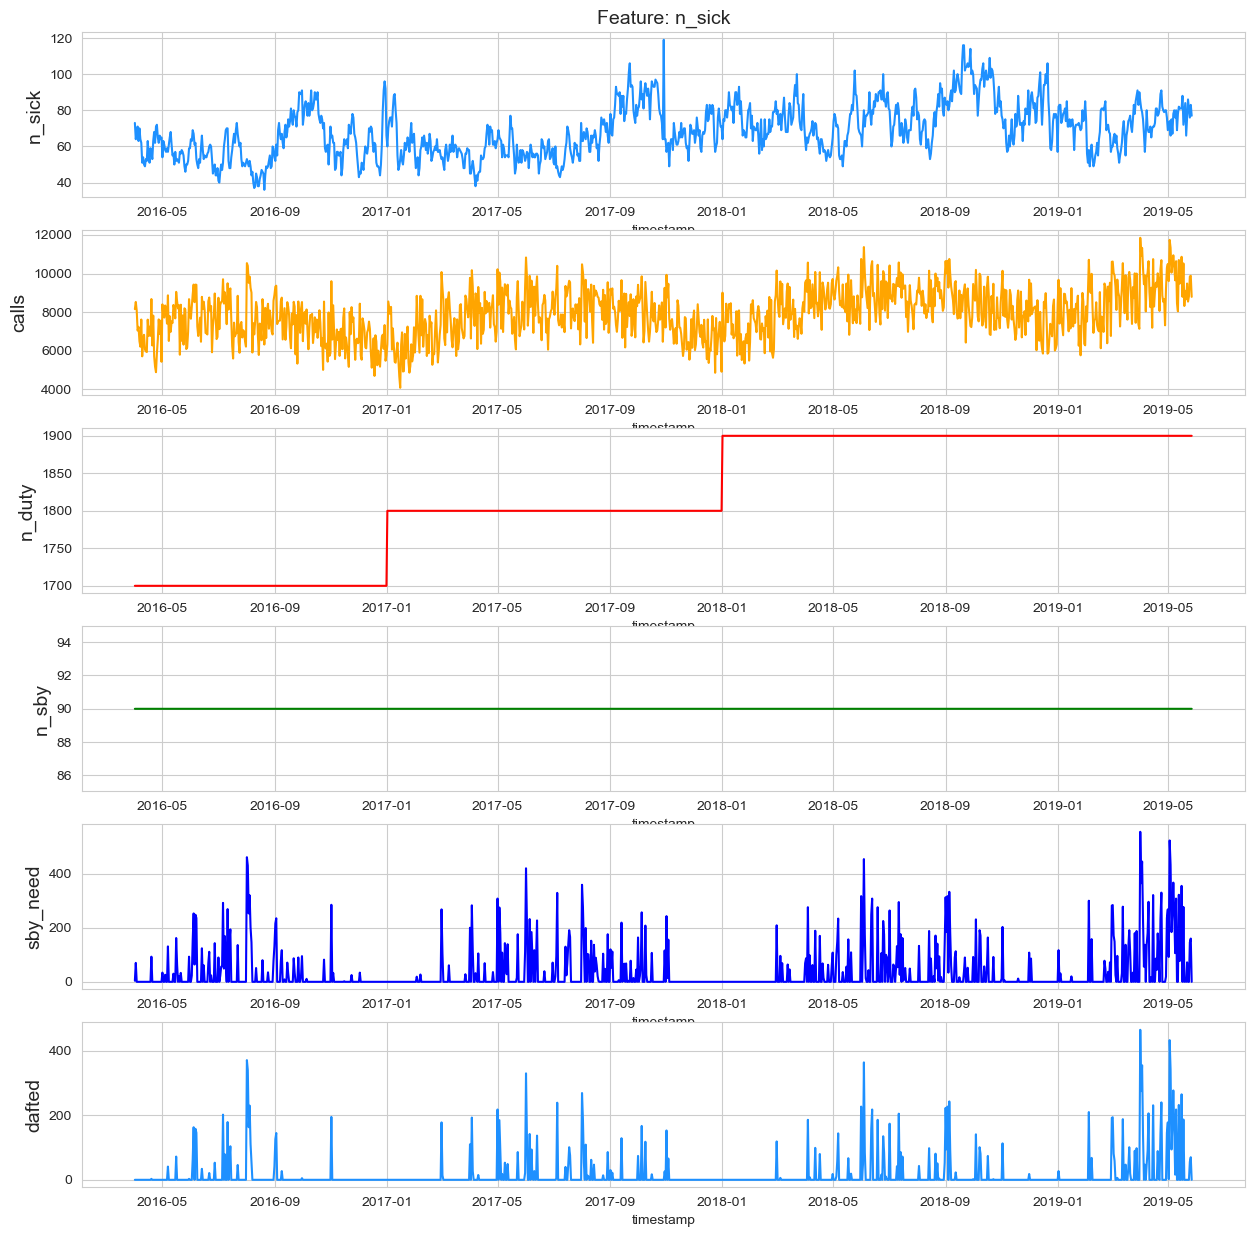

In [17]:
f, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 15))

sns.lineplot(x=df.index, y=df.n_sick, ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: n_sick', fontsize=14)
ax[0].set_ylabel(ylabel='n_sick', fontsize=14)


sns.lineplot(x=df.index, y=df.calls, ax=ax[1], color='orange')
#ax[1].set_title('Feature: calls', fontsize=14)
ax[1].set_ylabel(ylabel='calls', fontsize=14)


sns.lineplot(x=df.index, y=df.n_duty, ax=ax[2], color='red')
#ax[2].set_title('Feature: n_duty', fontsize=14)
ax[2].set_ylabel(ylabel='n_duty', fontsize=14)


sns.lineplot(x=df.index, y=df.n_sby, ax=ax[3], color='green')
#ax[3].set_title('Feature: n_sby', fontsize=14)
ax[3].set_ylabel(ylabel='n_sby', fontsize=14)


sns.lineplot(x=df.index, y=df.sby_need, ax=ax[4], color='blue')
#ax[4].set_title('Target: sby_need', fontsize=14)
ax[4].set_ylabel(ylabel='sby_need', fontsize=14)


sns.lineplot(x=df.index, y=df.dafted, ax=ax[5], color='dodgerblue')
#ax[5].set_title('Target: dafted', fontsize=14)
ax[5].set_ylabel(ylabel='dafted', fontsize=14)


for i in range(6):
    ax[i].set_xlim()


plt.savefig('images/lineplot.png', bbox_inches='tight')
  
plt.show()

### we can recognize a seasonal pettern with light growth of sby_need

## 5- EDA

### - Feature drop

In [18]:
data = df.copy()

In [19]:
# drop 'n_sby','dafted, n_duty' column due to discution of correlation and data understanding 
data = data.drop(['n_sby','dafted','n_duty'], axis =1).copy()


In [20]:
# save data
filepath = Path('Data/sickness_table_droppingfeatures_final.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data.to_csv(filepath)  

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152 entries, 2016-04-01 to 2019-05-27
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1152 non-null   object 
 1   n_sick    1152 non-null   int64  
 2   calls     1152 non-null   float64
 3   sby_need  1152 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 45.0+ KB


In [22]:
data.head(3)

,date,n_sick,calls,sby_need
timestamp,,,,
2016-04-01,2016-04-01,73,8154.0,4.0
2016-04-02,2016-04-02,64,8526.0,70.0
2016-04-03,2016-04-03,68,8088.0,0.0


### - Feature extraction

### add actual_duty

In [23]:
data['actual_duty'] = df['n_duty'] - data['n_sick'] + data['sby_need']

### - extract features from date

In [24]:
#add date column as index
data['date']= data.index.copy()

In [25]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.week
data['day'] = data['date'].dt.day
data['DayOfWeek']=data['date'].dt.day_name()
data['NumDayOfWeek']=data['date'].dt.dayofweek
data['qaurter']=data['date'].dt.quarter

### - add percentage feature

In [26]:
percantage = (data.sby_need / df.n_sby) * 100

In [27]:
data['percantage'] = percantage

In [28]:
data.percantage.mean()

38.576388888888886

In [29]:
percantage_nonzero = (df.where(df.sby_need != 0)/df.n_sby)

In [30]:
perc = (data['sby_need'].where(df.sby_need > df.n_sby))

In [31]:
perc.describe()

count    171.000000
mean     200.052632
std       94.488235
min       91.000000
25%      129.000000
50%      176.000000
75%      258.500000
max      555.000000
Name: sby_need, dtype: float64

In [32]:
data.columns

Index(['date', 'n_sick', 'calls', 'sby_need', 'actual_duty', 'year', 'month',
       'week', 'day', 'DayOfWeek', 'NumDayOfWeek', 'qaurter', 'percantage'],
      dtype='object')

### Adding Holidays

Source: https://towardsdatascience.com/the-easiest-way-to-identify-holidays-in-python-58333176af4f

In [33]:
import holidays


In [34]:
for holiday in holidays.Germany(years=[2016,2017,2018, 2019]).items():
    print(holiday)

(datetime.date(2016, 1, 1), 'Neujahr')
(datetime.date(2016, 3, 25), 'Karfreitag')
(datetime.date(2016, 3, 28), 'Ostermontag')
(datetime.date(2016, 5, 1), 'Erster Mai')
(datetime.date(2016, 5, 5), 'Christi Himmelfahrt')
(datetime.date(2016, 5, 16), 'Pfingstmontag')
(datetime.date(2016, 10, 3), 'Tag der Deutschen Einheit')
(datetime.date(2016, 12, 25), 'Erster Weihnachtstag')
(datetime.date(2016, 12, 26), 'Zweiter Weihnachtstag')
(datetime.date(2017, 1, 1), 'Neujahr')
(datetime.date(2017, 4, 14), 'Karfreitag')
(datetime.date(2017, 4, 17), 'Ostermontag')
(datetime.date(2017, 5, 1), 'Erster Mai')
(datetime.date(2017, 5, 25), 'Christi Himmelfahrt')
(datetime.date(2017, 6, 5), 'Pfingstmontag')
(datetime.date(2017, 10, 3), 'Tag der Deutschen Einheit')
(datetime.date(2017, 10, 31), 'Reformationstag')
(datetime.date(2017, 12, 25), 'Erster Weihnachtstag')
(datetime.date(2017, 12, 26), 'Zweiter Weihnachtstag')
(datetime.date(2018, 1, 1), 'Neujahr')
(datetime.date(2018, 3, 30), 'Karfreitag')
(date

In [35]:
de_holidays = holidays.Germany(years=[2016, 2019])
range_of_dates = pd.date_range("2016-04-01", "2019-05-27")
holidays_de = pd.DataFrame(
    index=range_of_dates, 
    data={"is_holiday": [date in de_holidays for date in range_of_dates]}
)
holidays_de= holidays_de.astype(int)
holidays_de

,is_holiday
2016-04-01,0
2016-04-02,0
2016-04-03,0
2016-04-04,0
2016-04-05,0
...,...
2019-05-23,0
2019-05-24,0
2019-05-25,0
2019-05-26,0


In [36]:
data['holidays_de'] = holidays_de

In [37]:
data.head()

,date,n_sick,calls,sby_need,actual_duty,year,month,week,day,DayOfWeek,NumDayOfWeek,qaurter,percantage,holidays_de
timestamp,,,,,,,,,,,,,,
2016-04-01,2016-04-01,73,8154.0,4.0,1631.0,2016,4,13,1,Friday,4,2,4.444444,0
2016-04-02,2016-04-02,64,8526.0,70.0,1706.0,2016,4,13,2,Saturday,5,2,77.777778,0
2016-04-03,2016-04-03,68,8088.0,0.0,1632.0,2016,4,13,3,Sunday,6,2,0.000000,0
2016-04-04,2016-04-04,71,7044.0,0.0,1629.0,2016,4,14,4,Monday,0,2,0.000000,0
2016-04-05,2016-04-05,63,7236.0,0.0,1637.0,2016,4,14,5,Tuesday,1,2,0.000000,0


In [38]:
holid= data.loc[data['holidays_de'] == 1]


<Axes: xlabel='calls', ylabel='holidays_de'>

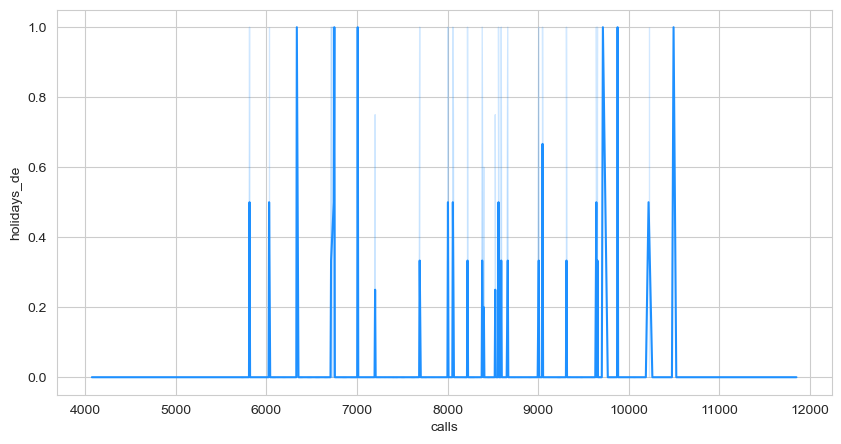

In [39]:
plt.figure(figsize=(10,5))

sns.lineplot(x=data.calls , y=data.holidays_de, color='dodgerblue')


In [40]:
#Reorder columns
new_cols = ['date','n_sick', 'calls',  'actual_duty',  'year', 'month', 'week',
       'day',  'NumDayOfWeek', 'qaurter','holidays_de','percantage','sby_need']

data=data.reindex(columns=new_cols)
data.head(1)

,date,n_sick,calls,actual_duty,year,month,week,day,NumDayOfWeek,qaurter,holidays_de,percantage,sby_need
timestamp,,,,,,,,,,,,,
2016-04-01,2016-04-01,73,8154.0,1631.0,2016,4,13,1,4,2,0,4.444444,4.0


In [41]:
# save data
filepath = Path('Data/sickness_table_addedFeatures_final.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data.to_csv(filepath) 

### Corelation with new features

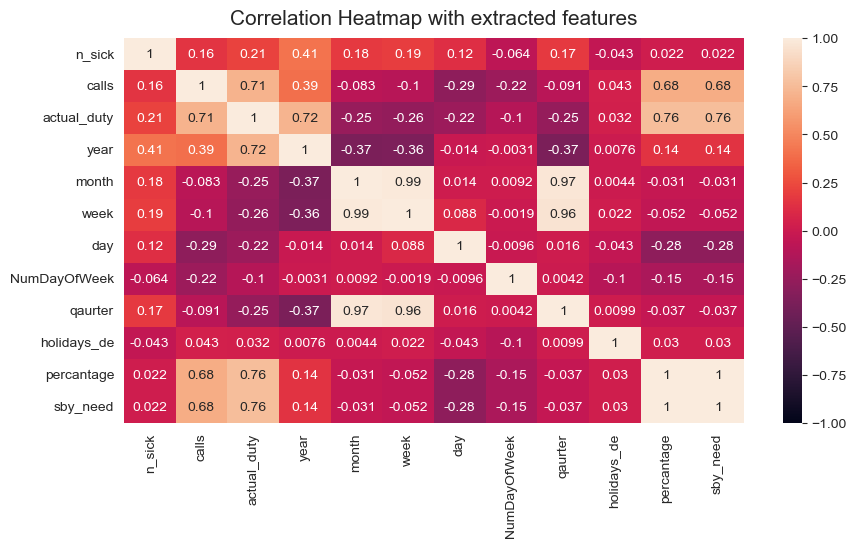

In [42]:
plt.figure(figsize=(10, 5))

heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap with extracted features', fontdict={'fontsize':15}, pad=10);
# save the figure
plt.savefig('images/correlation_Heatmap.png', dpi=300, bbox_inches='tight')

In [43]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
n_sick,1152.0,68.808160,14.293942,36.0,58.00,68.0,78.000000,119.000000
calls,1152.0,7919.531250,1290.063571,4074.0,6978.00,7932.0,8827.500000,11850.000000
actual_duty,1152.0,1786.483507,114.121491,1604.0,1721.75,1796.0,1834.000000,2370.000000
year,1152.0,2017.333333,0.977594,2016.0,2017.00,2017.0,2018.000000,2019.000000
month,1152.0,6.424479,3.394101,1.0,4.00,6.0,9.000000,12.000000
week,1152.0,26.023438,14.770423,1.0,14.00,25.0,39.000000,52.000000
day,1152.0,15.674479,8.778030,1.0,8.00,16.0,23.000000,31.000000
NumDayOfWeek,1152.0,3.002604,2.002386,0.0,1.00,3.0,5.000000,6.000000
qaurter,1152.0,2.484375,1.094858,1.0,2.00,2.0,3.000000,4.000000
holidays_de,1152.0,0.025174,0.156720,0.0,0.00,0.0,0.000000,1.000000


In [44]:
data.mean()

n_sick            68.808160
calls           7919.531250
actual_duty     1786.483507
year            2017.333333
month              6.424479
week              26.023438
day               15.674479
NumDayOfWeek       3.002604
qaurter            2.484375
holidays_de        0.025174
percantage        38.576389
sby_need          34.718750
dtype: float64

### Visualize the data according to Years

==


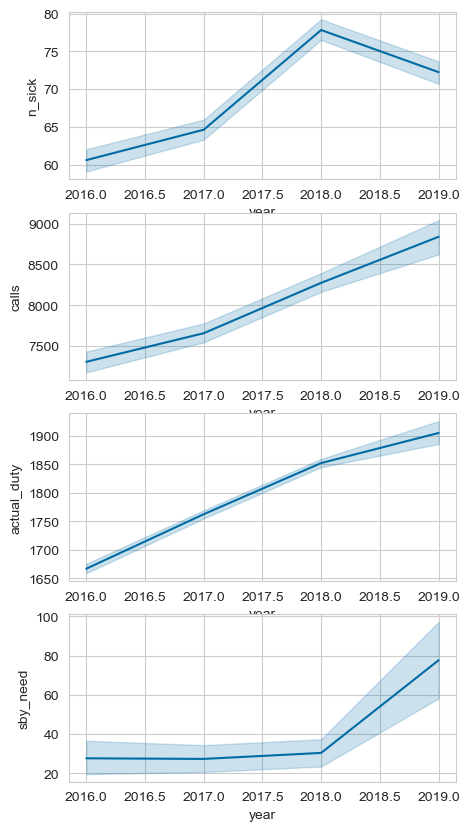

<Figure size 2000x1000 with 0 Axes>

In [45]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(5, 10))
sns.set(font_scale=0.9)
sns.lineplot(x=data.year, y=data.n_sick, ax=ax[0])
#ax[0].set_title('Feature: n_sick', fontsize=10)
ax[0].set_ylabel(ylabel='n_sick', fontsize=10)


sns.lineplot(x=data.year, y=data.calls, ax=ax[1])
#ax[1].set_title('Feature: calls', fontsize=10)
ax[1].set_ylabel(ylabel='calls', fontsize=10)


sns.lineplot(x=data.year, y=data.actual_duty, ax=ax[2])
#ax[2].set_title('Target: actual_duty', fontsize=10)
ax[2].set_ylabel(ylabel='actual_duty', fontsize=10)


sns.lineplot(x=data.year, y=data.sby_need, ax=ax[3])
#ax[3].set_title('Target: sby_need', fontsize=10)
ax[3].set_ylabel(ylabel='sby_need', fontsize=10)
print("==")

for i in range(4):
    
    ax[i].set_xlim()
    
 
    
plt.show()
# save the figure
plt.savefig('images/visual_year.png', dpi=300, bbox_inches='tight')

### monthly, weekly, daily boxplot

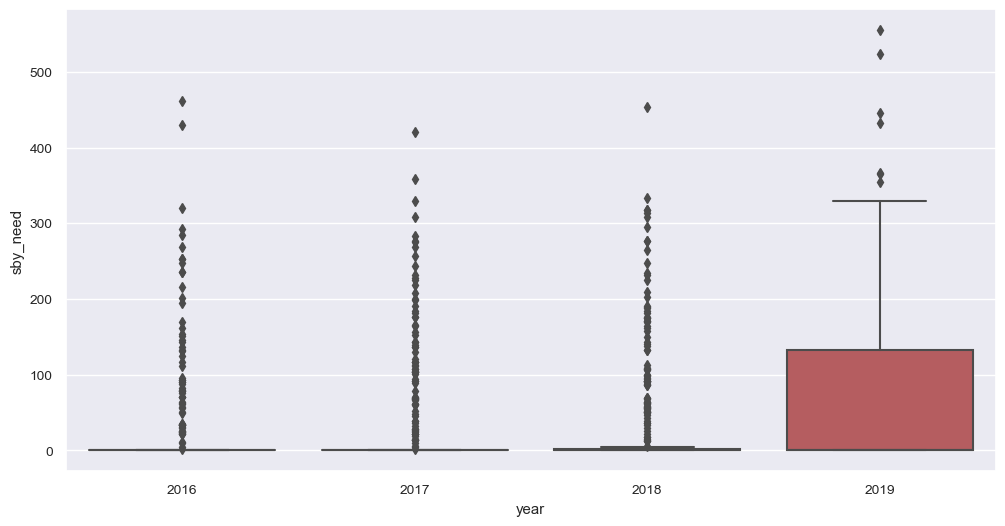

<Figure size 2000x1000 with 0 Axes>

In [46]:
plt.figure(figsize=(12,6))
sns.boxplot( x=data['year'],  y=data['sby_need'])
plt.show()
# save the figure
plt.savefig('images/y_boxplots.png', dpi=300, bbox_inches='tight')

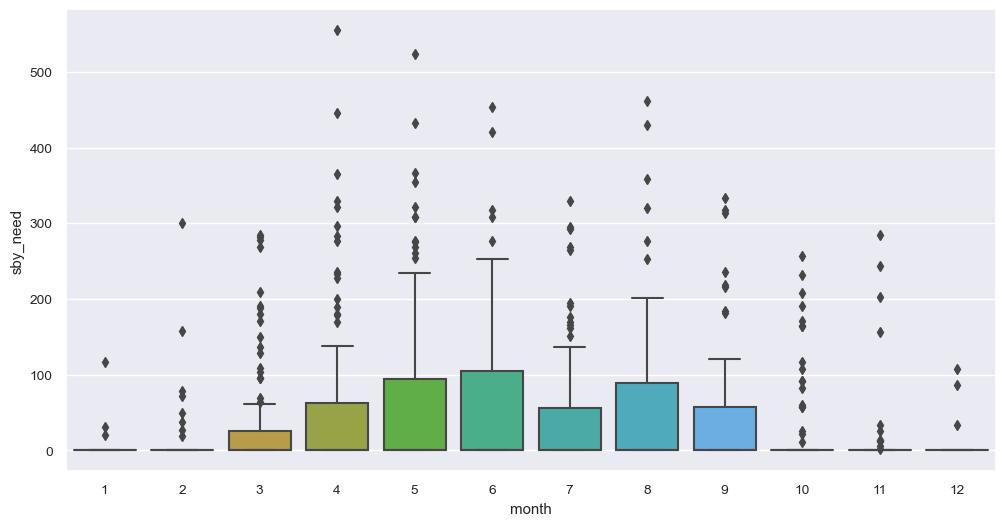

<Figure size 2000x1000 with 0 Axes>

In [47]:
plt.figure(figsize=(12,6))
sns.boxplot( x=data['month'],  y=data['sby_need'])
plt.show()
# save the figure
plt.savefig('images/m_boxplots.png', dpi=300, bbox_inches='tight')

we notice increased demand between March and September, Mai and June max

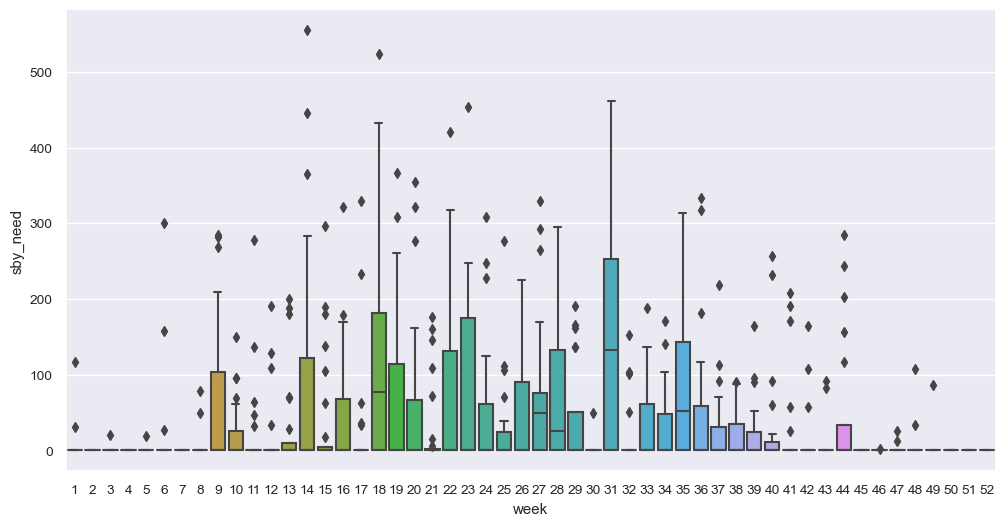

<Figure size 2000x1000 with 0 Axes>

In [48]:
plt.figure(figsize=(12,6))
           
sns.boxplot( x=data['week'],  y=data['sby_need'])
plt.show()
# save the figure
plt.savefig('images/w_boxplots.png', dpi=300, bbox_inches='tight')

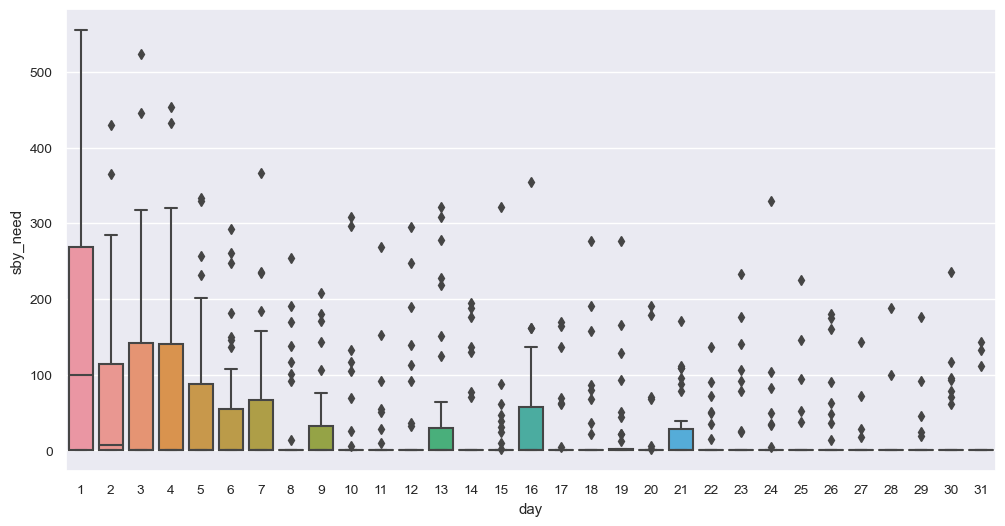

<Figure size 2000x1000 with 0 Axes>

In [49]:
plt.figure(figsize=(12,6))
sns.boxplot( x=data['day'],  y=data['sby_need'])
plt.show()
# save the figure
plt.savefig('images/d_boxplots.png', dpi=300, bbox_inches='tight')

We notice increase demand in the first week of the month

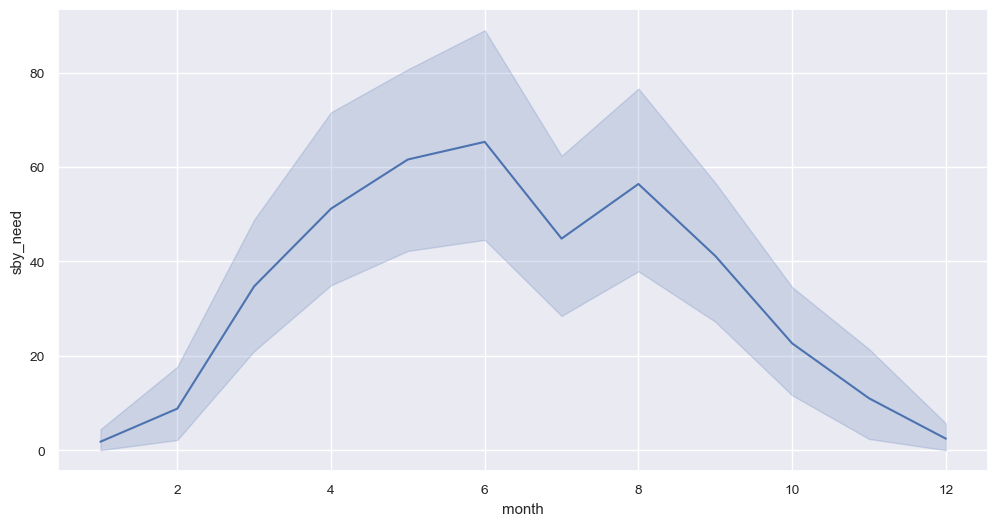

<Figure size 2000x1000 with 0 Axes>

In [50]:
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='month', y='sby_need')
plt.show()
# save the figure
plt.savefig('images/monthly_lineplot.png', dpi=300, bbox_inches='tight')

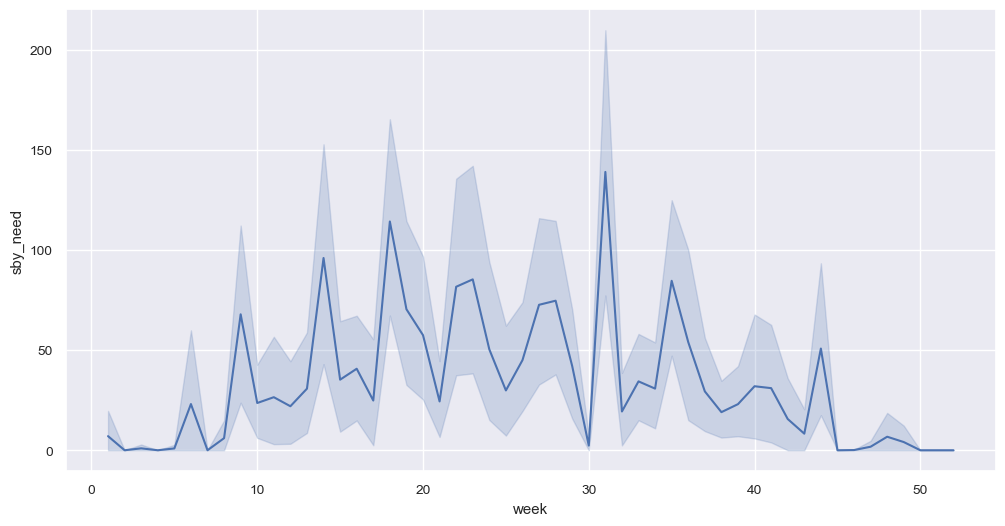

<Figure size 2000x1000 with 0 Axes>

In [51]:
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='week', y='sby_need')
plt.show()
# save the figure
plt.savefig('images/weekly_lineplot.png', dpi=300, bbox_inches='tight')

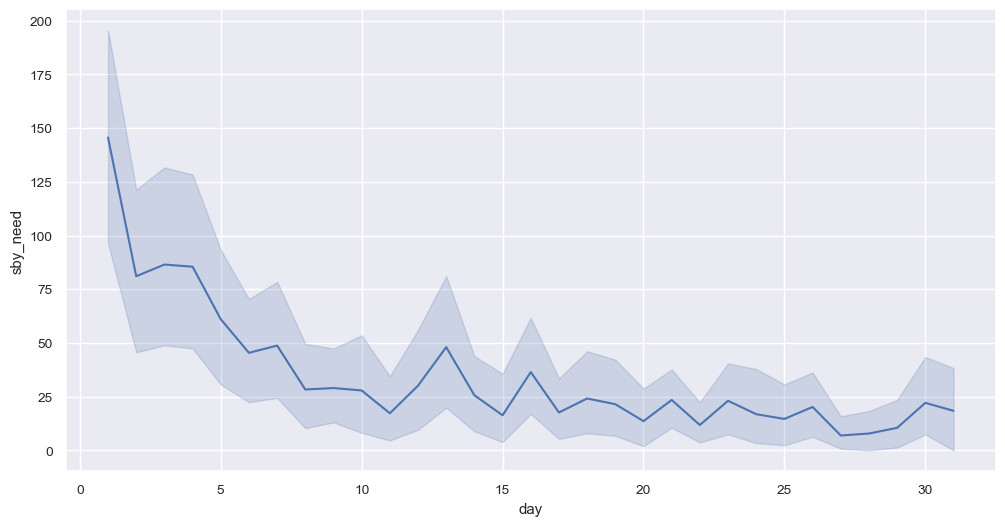

<Figure size 2000x1000 with 0 Axes>

In [52]:
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='day', y='sby_need')
plt.show()
# save the figure
plt.savefig('images/daily_lineplot.png', dpi=300, bbox_inches='tight')

### # above 400 can be conciderd as outliers!

In [53]:
data.head(3)

,date,n_sick,calls,actual_duty,year,month,week,day,NumDayOfWeek,qaurter,holidays_de,percantage,sby_need
timestamp,,,,,,,,,,,,,
2016-04-01,2016-04-01,73,8154.0,1631.0,2016,4,13,1,4,2,0,4.444444,4.0
2016-04-02,2016-04-02,64,8526.0,1706.0,2016,4,13,2,5,2,0,77.777778,70.0
2016-04-03,2016-04-03,68,8088.0,1632.0,2016,4,13,3,6,2,0,0.000000,0.0


In [54]:
filter = data.where(data['sby_need']<400).copy()

filter.count()

date            1144
n_sick          1144
calls           1144
actual_duty     1144
year            1144
month           1144
week            1144
day             1144
NumDayOfWeek    1144
qaurter         1144
holidays_de     1144
percantage      1144
sby_need        1144
dtype: int64

### Note: XGBoost can handle outliers automatically 

In [55]:
data_outl = data

In [56]:
#'Data/sickness_table_addedFeatures_final.csv'
#data.set_index('timestamp', inplace = True)
#data.index= pd.to_datetime(data.index)

data_outl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152 entries, 2016-04-01 to 2019-05-27
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1152 non-null   datetime64[ns]
 1   n_sick        1152 non-null   int64         
 2   calls         1152 non-null   float64       
 3   actual_duty   1152 non-null   float64       
 4   year          1152 non-null   int64         
 5   month         1152 non-null   int64         
 6   week          1152 non-null   int64         
 7   day           1152 non-null   int64         
 8   NumDayOfWeek  1152 non-null   int64         
 9   qaurter       1152 non-null   int64         
 10  holidays_de   1152 non-null   int64         
 11  percantage    1152 non-null   float64       
 12  sby_need      1152 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(8)
memory usage: 158.3 KB


### the percentage of activated drivers above n_sby =90

In [57]:
(perc.count()/data.shape[0])*100

14.84375

In [58]:
none_Zero= data.where(data.sby_need != 0).count()
none_Zero/1152

date            0.263021
n_sick          0.263021
calls           0.263021
actual_duty     0.263021
year            0.263021
month           0.263021
week            0.263021
day             0.263021
NumDayOfWeek    0.263021
qaurter         0.263021
holidays_de     0.263021
percantage      0.263021
sby_need        0.263021
dtype: float64

In [59]:
none_Zero_percentage= (none_Zero/df.shape[0])*100
none_Zero_percentage

date            26.302083
n_sick          26.302083
calls           26.302083
actual_duty     26.302083
year            26.302083
month           26.302083
week            26.302083
day             26.302083
NumDayOfWeek    26.302083
qaurter         26.302083
holidays_de     26.302083
percantage      26.302083
sby_need        26.302083
dtype: float64

### we see that only in about 26.3 % of the time standby drivers were activated

In [60]:
# save data
filepath = Path('Data/sickness_table_clean_final.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data_outl.to_csv(filepath) 

# 6- Model Building

In [61]:
data_clean = pd.read_csv('Data/sickness_table_clean_final.csv')

data_clean.set_index('timestamp', inplace = True)
data_clean.index= pd.to_datetime(data_clean.index)


data_clean.head(3)

,date,n_sick,calls,actual_duty,year,month,week,day,NumDayOfWeek,qaurter,holidays_de,percantage,sby_need
timestamp,,,,,,,,,,,,,
2016-04-01,2016-04-01,73,8154.0,1631.0,2016,4,13,1,4,2,0,4.444444,4.0
2016-04-02,2016-04-02,64,8526.0,1706.0,2016,4,13,2,5,2,0,77.777778,70.0
2016-04-03,2016-04-03,68,8088.0,1632.0,2016,4,13,3,6,2,0,0.000000,0.0


## Model

### Split the data to train/test

In [62]:
formatt ='%Y-%m-%d'
split_date =  datetime.datetime.strptime('2018-08-01',formatt)
data_train  = data_clean.loc[data_clean.index <= split_date].copy()
data_test  = data_clean.loc[data_clean.index > split_date].copy()

In [63]:
data_train.shape

(853, 13)

In [64]:
data_test.shape

(299, 13)

In [65]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152 entries, 2016-04-01 to 2019-05-27
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1152 non-null   object 
 1   n_sick        1152 non-null   int64  
 2   calls         1152 non-null   float64
 3   actual_duty   1152 non-null   float64
 4   year          1152 non-null   int64  
 5   month         1152 non-null   int64  
 6   week          1152 non-null   int64  
 7   day           1152 non-null   int64  
 8   NumDayOfWeek  1152 non-null   int64  
 9   qaurter       1152 non-null   int64  
 10  holidays_de   1152 non-null   int64  
 11  percantage    1152 non-null   float64
 12  sby_need      1152 non-null   float64
dtypes: float64(4), int64(8), object(1)
memory usage: 126.0+ KB


## Baseline model

In [66]:
def create_features_base(datas, label=None):

    X = datas[['n_sick', 'calls']]
    if label:
     y = datas[label]
     return X, y
     return X

In [67]:
X_train_b, y_train_b = create_features_base (data_train , label='sby_need')
X_test_b, y_test_b =create_features_base (data_test , label='sby_need')

### XGBoost Baseline Model

In [68]:
reg_base = XGBRegressor(n_estimators = 1000, early_stopping_rounds =50, learning_rate =0.01)
reg_base.fit(X_train_b,y_train_b,
       eval_set=[(X_train_b, y_train_b), (X_test_b, y_test_b)], eval_metric='rmse' , verbose=100)

[22:12:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:73.96831	validation_1-rmse:113.30414
[100]	validation_0-rmse:35.43432	validation_1-rmse:48.98381
[200]	validation_0-rmse:21.87021	validation_1-rmse:35.12352
[300]	validation_0-rmse:16.62750	validation_1-rmse:32.19929
[400]	validation_0-rmse:14.12642	validation_1-rmse:31.77256
[500]	validation_0-rmse:12.75795	validation_1-rmse:31.79312
[600]	validation_0-rmse:11.98703	validation_1-rmse:31.86147
[700]	validation_0-rmse:11.38846	validation_1-rmse:32.10565
[800]	validation_0-rmse:10.95588	validation_1-rmse:32.40173
[900]	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [69]:
data.sby_need.mean()

34.71875

In [70]:
data.sby_need.std()

79.6942510683482

## We notice that baseline rmse results are close to the mean of sb_need!!!, so we could use the mean as a baseline

### Optimize Parameters using cross validation GridSearchCV()

In [71]:
data_clean.columns

Index(['date', 'n_sick', 'calls', 'actual_duty', 'year', 'month', 'week',
       'day', 'NumDayOfWeek', 'qaurter', 'holidays_de', 'percantage',
       'sby_need'],
      dtype='object')

In [72]:
def create_features(datas, label=None):
    datas['date'] = datas.index
    datas['year'] = datas['date'].dt.year
    datas['month'] = datas['date'].dt.month
    datas['week'] = datas['date'].dt.week
    datas['day'] = datas['date'].dt.day
    #datas['DayOfWeek']=datas['date'].dt.day_name()
    datas['NumDayOfWeek']=datas['date'].dt.dayofweek
    datas['qaurter']=datas['date'].dt.quarter
    X = datas[['n_sick', 'calls', 'actual_duty', 'year', 'month', 'week',
       'day', 'NumDayOfWeek', 'qaurter' , 'percantage', 'holidays_de']]
    if label:
        y = datas[label]
        return X, y
    return X

In [73]:
X_train, y_train = create_features (data_train, label='sby_need')
X_test, y_test =create_features (data_test, label='sby_need')

In [74]:
# A parameter grid for XGBoost
#https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
params = {
    'min_child_weight': [3 , 4, 5], #It defines the minimum sum of weights of all observations required in a child.
    'gamma': [i / 10.0 for i in range(1, 6)], #Gamma specifies the minimum loss reduction required to make a split.
    'subsample': [i / 10.0 for i in range(6, 11)],#It denotes the fraction of observations to be randomly samples for each tree.
    'colsample_bytree': [i / 10.0 for i in range(6, 11)], #is the subsample ratio of columns when constructing each tree. 
                                                          #Subsampling occurs once for every tree constructed.
    'max_depth': [2, 3, 4], #The maximum depth of a tree
    #'reg_alpha': [1.5,2,3], # L1 regularization
    'reg_lambda': [1.5 , 2 , 3] # [0, 0.5, 1,2,3]  
    # L2 regularization term on weights. Increasing this value will make model more conservative. 
}
# Initialize XGB and GridSearch

xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror') #regression with squared loss.


grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train, y_train)
gridcv_xgb = grid.best_estimator_


In [75]:
print('METRICS RESULTS OF XGBOOST WITH "percantage" FEATURE:')
print('r2_score: ' ,float("{:.4f}".format(r2_score(y_test, gridcv_xgb.predict(X_test)))))
print('MAE     : ', float("{:.4f}".format(mean_absolute_error(y_test, gridcv_xgb.predict(X_test)))))
print('RMSE    : ', float("{:.4f}".format(np.sqrt(mean_squared_error(y_test, gridcv_xgb.predict(X_test))))))

METRICS RESULTS OF XGBOOST WITH "percantage" FEATURE:
r2_score:  0.9936
MAE     :  1.5709
RMSE    :  8.1131


In [76]:
grid.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.3,
 'max_depth': 3,
 'min_child_weight': 3,
 'reg_lambda': 3,
 'subsample': 1.0}

In [77]:
gridcv_xgb.evals_result

<bound method XGBModel.evals_result of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, nthread=-1, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=3, scale_pos_weight=1,
             subsample=1.0, tree_method='exact', validate_parameters=1,
             verbosity=None)>

### plot feature importance

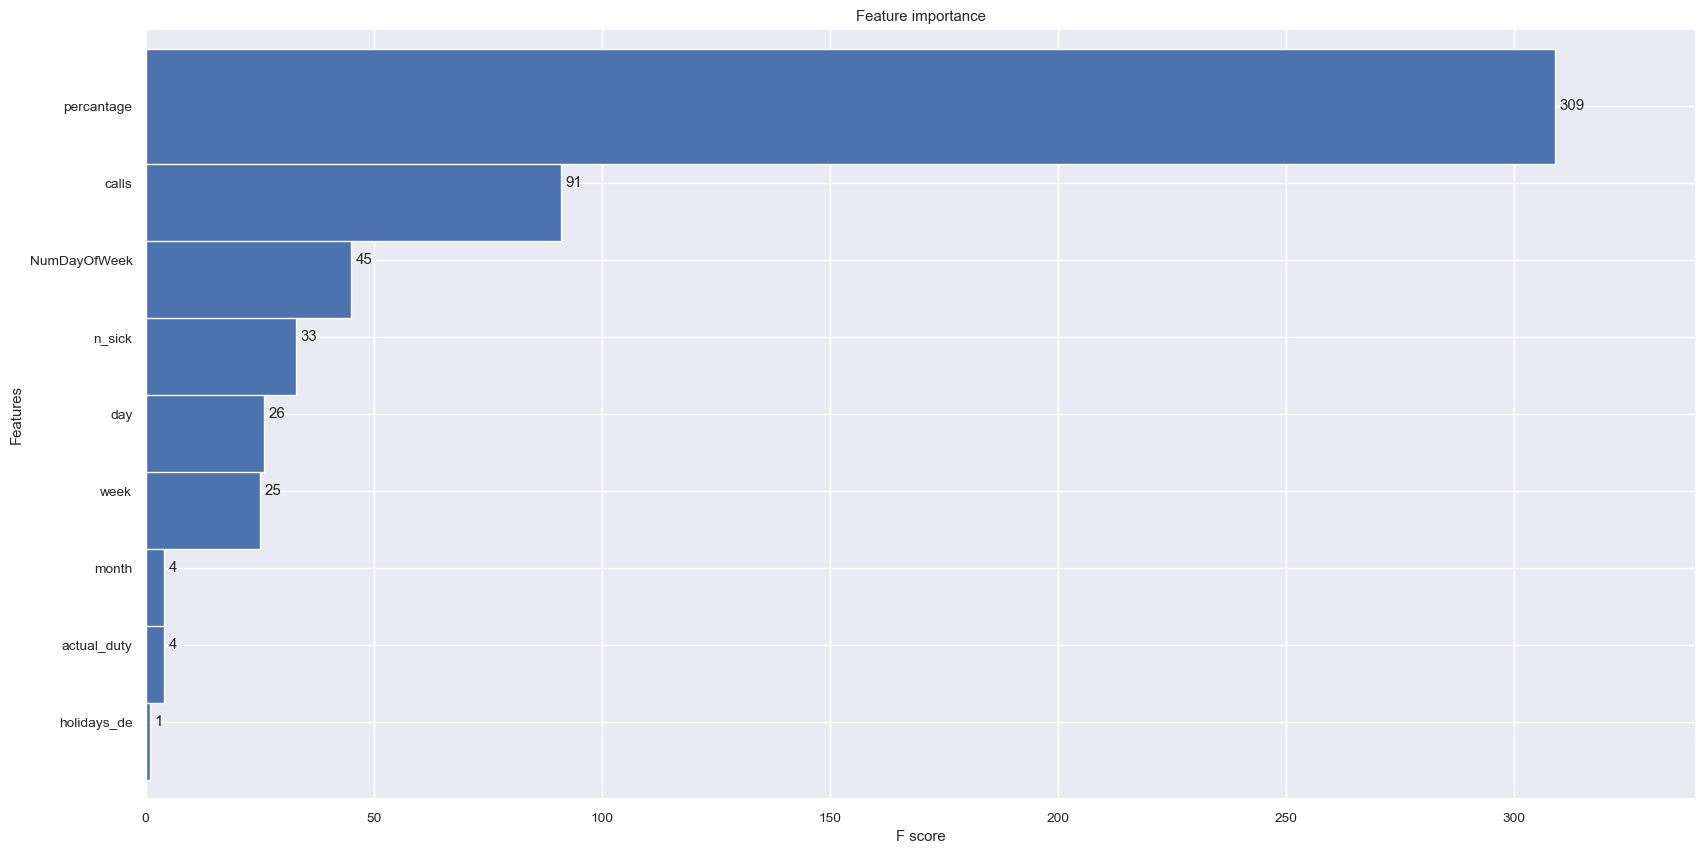

In [78]:
plot_importance(gridcv_xgb, height=1.5)
# save the figure
plt.savefig('images/feature_importance.png', dpi=300, bbox_inches='tight')

### Validation: forcasting on test set

In [79]:
data_test['Prediction'] = gridcv_xgb.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

In [80]:
# evaluate predictions
score = r2_score(y_test, gridcv_xgb.predict(X_test))
print("score: %.2f%%" % (score * 100.0))

score: 99.36%


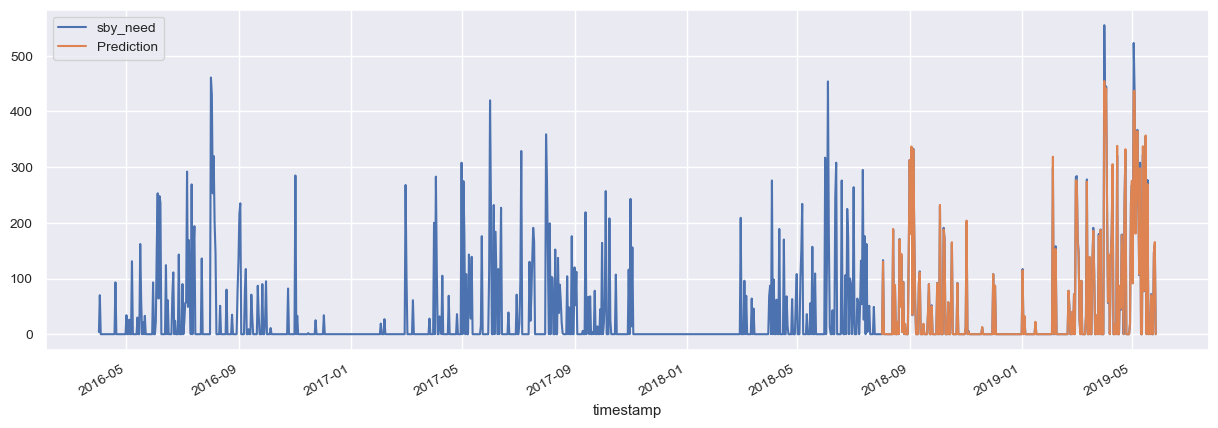

In [81]:
result = data_all[['sby_need','Prediction']].plot(figsize=(15, 5))
# save the figure
plt.savefig('images/visual_pred.png', dpi=300, bbox_inches='tight')

In [82]:
data_all.head()

,date,n_sick,calls,actual_duty,year,month,week,day,NumDayOfWeek,qaurter,holidays_de,percantage,sby_need,Prediction
timestamp,,,,,,,,,,,,,,
2018-08-02,2018-08-02,79,9024.0,1821.0,2018,8,31,2,3,3,0,0.000000,0.0,0.285203
2018-08-03,2018-08-03,77,9780.0,1956.0,2018,8,31,3,4,3,0,147.777778,133.0,130.394196
2018-08-04,2018-08-04,64,8946.0,1836.0,2018,8,31,4,5,3,0,0.000000,0.0,0.207013
2018-08-05,2018-08-05,61,9054.0,1839.0,2018,8,31,5,6,3,0,0.000000,0.0,0.201508
2018-08-06,2018-08-06,68,8322.0,1832.0,2018,8,32,6,0,3,0,0.000000,0.0,0.037850


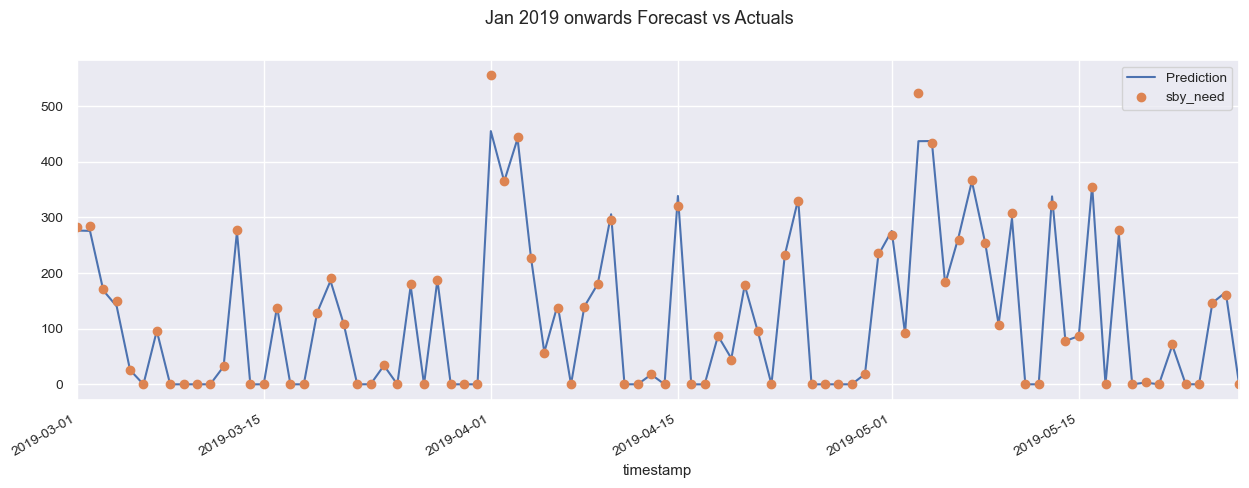

In [83]:
# Plot the forecast with the actuals
import matplotlib.dates as md

left = pd.to_datetime('2019-03-01', format = '%Y-%m-%d')
right = pd.to_datetime('2019-05-27', format = '%Y-%m-%d')

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)


#_ = df_all[['Prediction','sby_need']].plot(ax=ax, style=['-','o'])
#ax.set_xbound(lower='2019–05–28', upper='2019–06–27')

#ax.xaxis.set_major_locator(md.MonthLocator(interval = 1))
#ax.xaxis.set_major_formatter(md.DateFormatter('%b'))

ax.set_xlim([left, right])

_ = data_all[['Prediction','sby_need']].plot(ax=ax, style=['-','o'])


plot = plt.suptitle('Jan 2019 onwards Forecast vs Actuals')
#plt.show()
# save the figure
plt.savefig('images/visual_forcast_vs_actual.png', dpi=300, bbox_inches='tight')

## Building a model after Dropping percentage feature due to high corrality

In [84]:
data_nop = data_clean[['date', 'n_sick', 'calls', 'actual_duty', 'year', 'month', 'week',
       'day', 'NumDayOfWeek', 'qaurter', 'holidays_de', 'sby_need']].copy()

data_nop.head(3)

,date,n_sick,calls,actual_duty,year,month,week,day,NumDayOfWeek,qaurter,holidays_de,sby_need
timestamp,,,,,,,,,,,,
2016-04-01,2016-04-01,73,8154.0,1631.0,2016,4,13,1,4,2,0,4.0
2016-04-02,2016-04-02,64,8526.0,1706.0,2016,4,13,2,5,2,0,70.0
2016-04-03,2016-04-03,68,8088.0,1632.0,2016,4,13,3,6,2,0,0.0


In [85]:
# split the data

formatt ='%Y-%m-%d'
split_date =  datetime.datetime.strptime('2018-08-01',formatt)
data_train_  = data_nop.loc[data_nop.index <= split_date].copy()
data_test_  = data_nop.loc[data_nop.index > split_date].copy()

In [86]:
# features without percentage variable

def create_features_nop(datas, label=None):
    datas['date'] = datas.index
    datas['year'] = datas['date'].dt.year
    datas['month'] = datas['date'].dt.month
    datas['week'] = datas['date'].dt.week
    datas['day'] = datas['date'].dt.day
    datas['NumDayOfWeek']=datas['date'].dt.dayofweek
    datas['qaurter']=datas['date'].dt.quarter
    X = datas[['n_sick', 'calls', 'actual_duty', 'year', 'month', 'week',
       'day', 'NumDayOfWeek', 'qaurter' ,  'holidays_de']]
    if label:
        y = datas[label]
        return X, y
    return X

In [87]:
X_train_nop, y_train_nop = create_features_nop (data_train_, label='sby_need')
X_test_nop, y_test_nop =create_features_nop (data_test_, label='sby_need')

In [88]:
# A parameter grid for XGBoost
#https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
params_nop = {
    'min_child_weight': [3 , 4, 5], #It defines the minimum sum of weights of all observations required in a child.
    'gamma': [i / 10.0 for i in range(1, 6)], #Gamma specifies the minimum loss reduction required to make a split.
    'subsample': [i / 10.0 for i in range(6, 11)],#It denotes the fraction of observations to be randomly samples for each tree.
    'colsample_bytree': [i / 10.0 for i in range(6, 11)], #is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
    'max_depth': [2, 3, 4], #The maximum depth of a tree
    #'reg_alpha': [1.5,2,3], # L1 regularization
    'reg_lambda': [1.5 , 2 , 3] # [0, 0.5, 1,2,3]  
    # L2 regularization term on weights. Increasing this value will make model more conservative. 
}
# Initialize XGB and GridSearch

xgb_reg_nop = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror') #regression with squared loss.


grid_nop = GridSearchCV(xgb_reg_nop, params_nop)
grid_nop.fit(X_train_nop, y_train_nop)
gridcv_xgb_nop = grid_nop.best_estimator_


In [89]:
print('METRICS RESULTS OF XGBOOST AFTER DROPPING "percantage" FEATURE:')
print('r2_score: ' ,float("{:.4f}".format(r2_score(y_test_nop, gridcv_xgb_nop.predict(X_test_nop)))))
print('MAE     : ', float("{:.4f}".format(mean_absolute_error(y_test_nop, gridcv_xgb_nop.predict(X_test_nop)))))
print('RMSE    : ', float("{:.4f}".format(np.sqrt(mean_squared_error(y_test_nop, gridcv_xgb_nop.predict(X_test_nop))))))

METRICS RESULTS OF XGBOOST AFTER DROPPING "percantage" FEATURE:
r2_score:  0.9624
MAE     :  8.4828
RMSE    :  19.7268


In [90]:
evals_result_nop= gridcv_xgb_nop.evals_result
evals_result_nop

<bound method XGBModel.evals_result of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, nthread=-1, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)>

In [91]:
grid_nop.best_score_

0.9069889024259279

In [92]:
grid_nop.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.1,
 'max_depth': 2,
 'min_child_weight': 3,
 'reg_lambda': 1.5,
 'subsample': 0.8}

### Feature importance without percentage feature

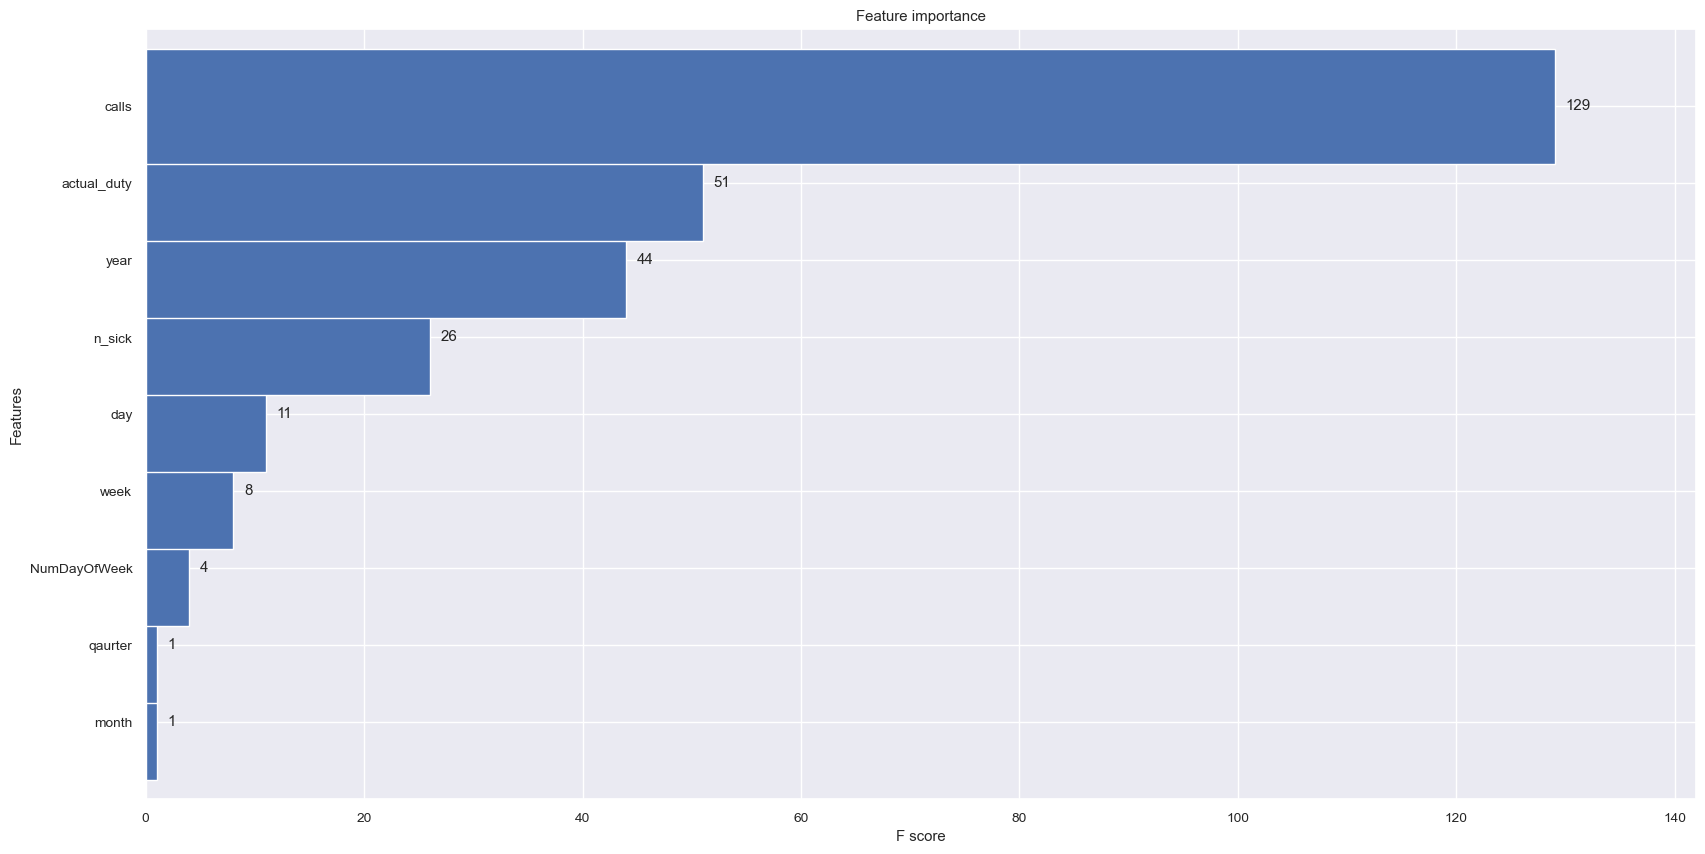

In [93]:
plot_importance(gridcv_xgb_nop, height=1.5)
# save the figure
plt.savefig('images/feature_importance_second.png', dpi=300, bbox_inches='tight')

In [94]:
data_test_nop = data_test_
data_test_nop['Prediction'] = gridcv_xgb_nop.predict(X_test_nop)
data_all_nop = pd.concat([data_test_, data_train_], sort=False)

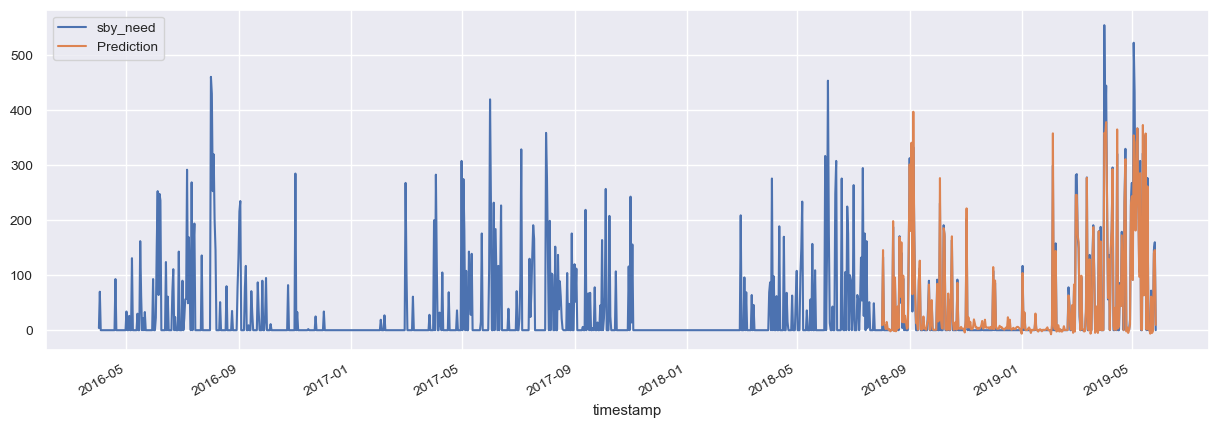

In [95]:
result_nop = data_all_nop[['sby_need','Prediction']].plot(figsize=(15, 5))
# save the figure
plt.savefig('images/visual_pred_nop.png', dpi=300, bbox_inches='tight')

# Add penalty sby_need mean
Adding the mean of sby_mean as the minimum prediction can keep areserved standby drivers less than the current situation.

In [96]:
data.sby_need.mean()

34.71875

In [97]:
data_test_penalty =data_test.copy()
penalty= data.sby_need.mean()

data_test_penalty['pred_penalty'] = data_test['Prediction'] 
for i in range (data_test_penalty.shape[0]):
    if data_test_penalty['pred_penalty'][i] < penalty:
        
        data_test_penalty['pred_penalty'][i]=  penalty

data_test_penalty.tail()

,date,n_sick,calls,actual_duty,year,month,week,day,NumDayOfWeek,qaurter,holidays_de,percantage,sby_need,Prediction,pred_penalty
timestamp,,,,,,,,,,,,,,,
2019-05-23,2019-05-23,86,8544.0,1814.0,2019,5,21,23,3,2,0,0.000000,0.0,0.242243,34.718750
2019-05-24,2019-05-24,81,8814.0,1819.0,2019,5,21,24,4,2,0,0.000000,0.0,-0.074894,34.718750
2019-05-25,2019-05-25,76,9846.0,1970.0,2019,5,21,25,5,2,0,162.222222,146.0,146.371109,146.371109
2019-05-26,2019-05-26,83,9882.0,1977.0,2019,5,21,26,6,2,0,177.777778,160.0,165.382278,165.382278
2019-05-27,2019-05-27,77,8790.0,1823.0,2019,5,22,27,0,2,0,0.000000,0.0,-0.109106,34.718750


In [98]:

data_penalty_all = pd.concat([data_test_penalty , data_train], sort=False)

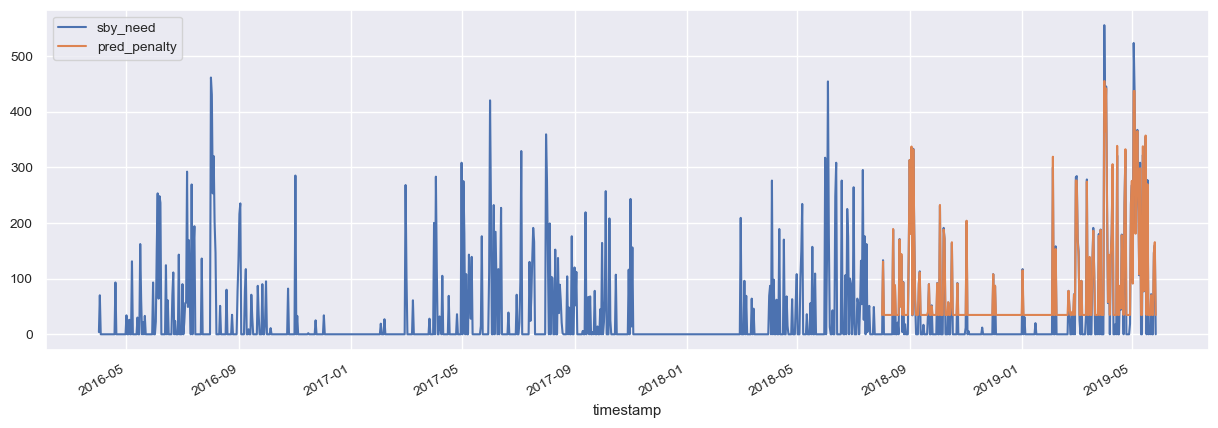

In [99]:
result_penalty = data_penalty_all[['sby_need','pred_penalty']].plot(figsize=(15, 5))
# save the figure
plt.savefig('images/visual_pred_penalty.png', dpi=300, bbox_inches='tight')

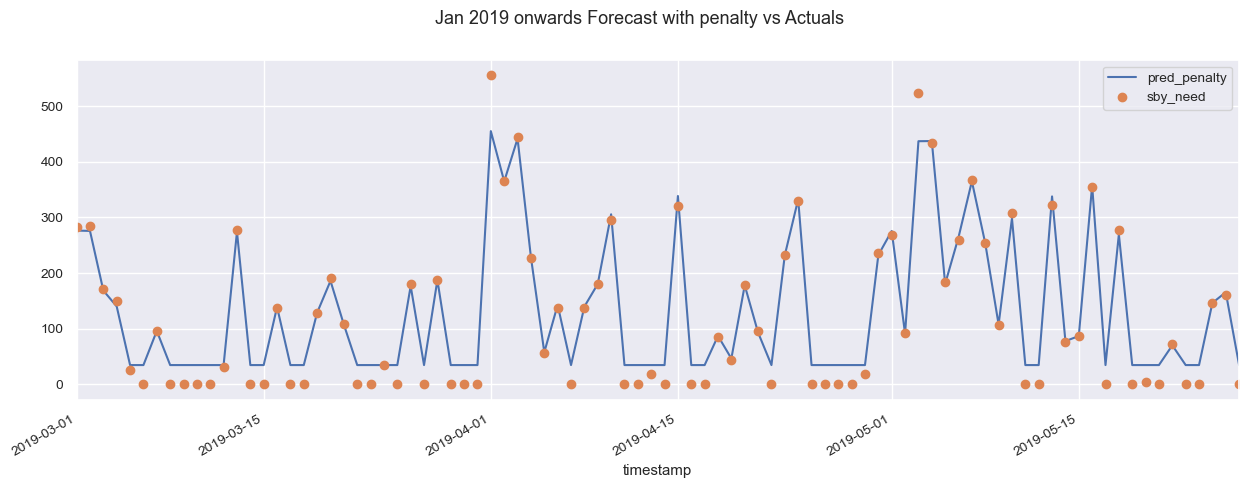

In [100]:
# Plot the penalty forecast  with the actuals
import matplotlib.dates as md

left = pd.to_datetime('2019-03-01', format = '%Y-%m-%d')
right = pd.to_datetime('2019-05-27', format = '%Y-%m-%d')

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)


#_ = df_all[['Prediction','sby_need']].plot(ax=ax, style=['-','o'])
#ax.set_xbound(lower='2019–05–28', upper='2019–06–27')

#ax.xaxis.set_major_locator(md.MonthLocator(interval = 1))
#ax.xaxis.set_major_formatter(md.DateFormatter('%b'))

ax.set_xlim([left, right])

result_penalty = data_penalty_all[['pred_penalty','sby_need']].plot(ax=ax, style=['-','o'])


plot = plt.suptitle('Jan 2019 onwards Forecast with penalty vs Actuals')
#plt.show()
# save the figure
plt.savefig('images/visual_forcast_with_penalty_vs_actual.png', dpi=300, bbox_inches='tight')

## Another solution n_sby
we can use the first prediction without penalty, but keep n_sby  = data.sby_need.mean()

### - calculate the percentage of activated sby dirvers

In [101]:
# Percentage in orginal data
percantage = (data.sby_need / df.n_sby) * 100
percantage.mean()

38.576388888888886

In [102]:
# Percentage in prediction

percantage_prediction = (data_all.Prediction / df.n_sby) * 100
percantage_prediction.mean()

58.05359982103781

In [103]:
# Percentage in prediction without 'percentage' feature

percantage_prediction_nop = (data_all_nop.Prediction / df.n_sby) * 100
percantage_prediction_nop.mean()


59.75582437933776

In [104]:
data_all.shape

(1152, 14)

In [105]:
none_Zero= data_all.where(data_all.Prediction >0 ).count()
none_Zero

date            212
n_sick          212
calls           212
actual_duty     212
year            212
month           212
week            212
day             212
NumDayOfWeek    212
qaurter         212
holidays_de     212
percantage      212
sby_need        212
Prediction      212
dtype: int64

In [106]:
none_Zero_percentage= (none_Zero/data_all.shape[0])*100
none_Zero_percentage

date            18.402778
n_sick          18.402778
calls           18.402778
actual_duty     18.402778
year            18.402778
month           18.402778
week            18.402778
day             18.402778
NumDayOfWeek    18.402778
qaurter         18.402778
holidays_de     18.402778
percantage      18.402778
sby_need        18.402778
Prediction      18.402778
dtype: float64

In [107]:
data_all.percantage.mean()

38.576388888888886

In [108]:
data_all.Prediction.mean()

52.24824

In [109]:
# percentage above  fixed number ofsby = 90

above90= data_all.where(data_all.Prediction >90 ).count()
perc_pred=(above90/data_all.shape[0])*100

In [110]:
perc_pred.mean()


5.729166666666666

In [111]:
# percentage above  fixed number ofsby = 90 without 'percentage' feature

above90_nop= data_all_nop.where(data_all_nop.Prediction >90 ).count()
perc_pred_nop=(above90/data_all_nop.shape[0])*100
perc_pred_nop.mean()

5.729166666666666

## Results:
### - the model percentage of activated drivers is higher than current status ==> goal is met.
### - the model  mean of activatad drivers above the fixed n_sby=90 is about 5.7% ==> goal is met.

## extra steps
### - More robust cross validation
### - Add more features (maybe from external sources) like weather, holidays etc.

# 7- Deploy

In [112]:
gridcv_xgb.save_model('json/model_final.json')

In [113]:
!ls -lh

total 8288
-rw-r--r--@  1 husam  staff   2.6M Apr 29 23:01 Archive.zip
drwxr-xr-x  10 husam  staff   320B Apr 29 20:56 Data
-rw-r--r--@  1 husam  staff   1.4M May 13 22:23 Task2 -Final.ipynb
-rw-r--r--   1 husam  staff    18K May  5 21:33 Test-Model-with-random.ipynb
drwxr-xr-x  24 husam  staff   768B May 13 22:32 images
drwxr-xr-x   3 husam  staff    96B Apr 29 22:59 json


In [114]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('json/model_final.json')

### See Test-Model-with-random.ipynb  as a dummy test

# End